In [1]:
cd ~/Workspace/compression-ml/

/home/navneedhmaudgalya/Workspace/compression-ml


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os 
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

from cifar_models import *
from utils.dataset import *
from utils.image_utils import *
from cifar_models.vgg import *
device = "cuda" if torch.cuda.is_available() else "cpu"

import matplotlib

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 13

In [2]:
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
  return total_params

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

BATCH_SIZE = 128
EPOCHS = 35

In [4]:
train_dset = CifarDataset("", train = True, transform = transform)
test_dset = CifarDataset("", train = False, transform = transform)

# train_dset = torchvision.datasets.CIFAR10(
#     root="~/Workspace/data", train=True, download=True, transform=transform
# )

# test_dset = torchvision.datasets.CIFAR10(
#     root="~/Workspace/data", train=False, download=True, transform=transform
# )

train_loader = DataLoader(train_dset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dset, batch_size = BATCH_SIZE, shuffle = False)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 8, 3)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = VGG('VGG11sss').to(device)
print(pytorch_count_params(net))

7754


In [6]:
def train(trainloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    accuracy = []
    losses = []
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return correct/total, train_loss/(50000/BATCH_SIZE) 

def test(testloader):
    softmax_output = nn.Softmax()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    metrics = []
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        return correct/total, test_loss/(10000/BATCH_SIZE) 
    

train_acc, train_loss, test_acc, test_loss = [], [], [], []
for epoch in tqdm(range(EPOCHS)):    
    train_a, train_l = train(train_loader)
    test_a, test_l = test(test_loader)
    
    train_acc.append(train_a)
    train_loss.append(train_l)
    test_acc.append(test_a)
    test_loss.append(test_l)
    
exp_name = "base_ssss_vgg11"
np.savez("exp_results/{}.npz".format(exp_name), train_acc=train_acc, train_loss=train_loss, test_acc=test_acc, test_loss=test_loss)
torch.save(net.state_dict(), "saved_models/{}.pt".format(exp_name))

100%|██████████| 35/35 [13:37<00:00, 23.34s/it]


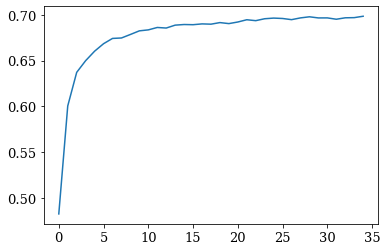

In [7]:
plt.plot(train_acc)

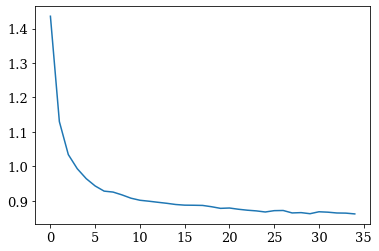

In [8]:
plt.plot(train_loss)

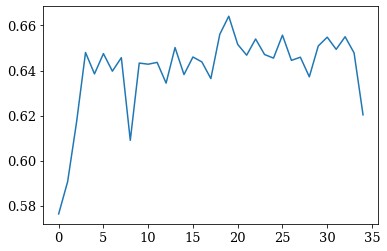

In [9]:
plt.plot(test_acc)

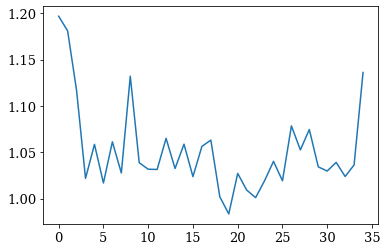

In [10]:
plt.plot(test_loss)

In [3]:
bls_bpp = [0.2612, 0.408, 0.519, 0.702, 0.837, 0.952, 1.08, 1.21, 1.359, 1.48712]
bls_full_bpp = [0.572, 0.719, 0.830, 0.928, 1.02]
other_bpp = [0.2841, 0.4564, 0.5248, 0.6483, 0.7346, ]
jpeg_bpp = [0.3559, 0.484, 0.7054, 1.034, 1.50, 1.91, 2.74]
jpeq_quality = [1,5,10,20,40,60,80,100]
param_counts = []
exp_results_folder = "exp_results/"

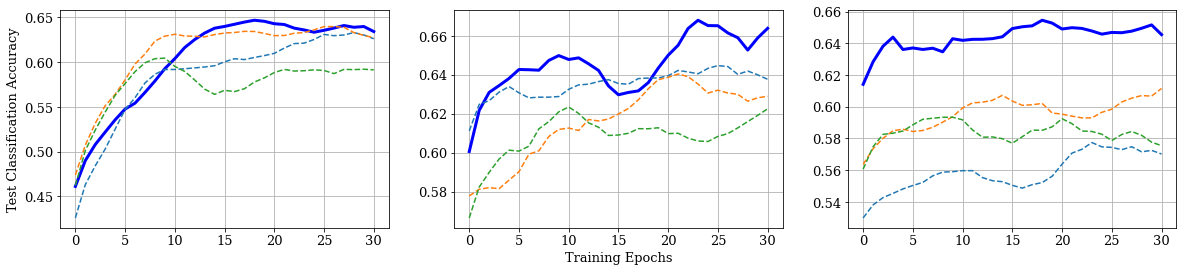

In [4]:
plt.figure(figsize=(20, 4))
base = np.load(exp_results_folder + "base_vgg11.npz")
base_sss = np.load(exp_results_folder +"base_sss_vgg11.npz")
bls33_sss = np.load(exp_results_folder +"bls33_sss_vgg11.npz")
bls17_sss = np.load(exp_results_folder +"bls17_sss_vgg11.npz")
bls24_sss = np.load(exp_results_folder +"bls24_sss_vgg11.npz")
bls17_vgg11 = np.load(exp_results_folder +"bls17_vgg11.npz")
bls12_sss = np.load(exp_results_folder +"bls12_sss_vgg11.npz")

base_ss = np.load(exp_results_folder +"base_ss_vgg11.npz")
bls33_ss = np.load(exp_results_folder +"bls33_ss_vgg11.npz")
bls17_ss = np.load(exp_results_folder +"bls17_ss_vgg11.npz")
bls24_ss = np.load(exp_results_folder +"bls24_ss_vgg11.npz")

base_ssss = np.load(exp_results_folder +"base_ssss_vgg11.npz")
bls33_ssss = np.load(exp_results_folder +"bls33_ssss_vgg11.npz")
bls17_ssss = np.load(exp_results_folder +"bls17_ssss_vgg11.npz")
bls24_ssss = np.load(exp_results_folder +"bls24_ssss_vgg11.npz")
bls12_ssss = np.load(exp_results_folder +"bls12_ssss_vgg11.npz")

base_sss_test = np.convolve(base_sss['test_acc'], np.ones(5)/5, mode='valid')
bls33_sss_test = np.convolve(bls33_sss['test_acc'], np.ones(5)/5, mode='valid')
bls24_sss_test = np.convolve(bls24_sss['test_acc'], np.ones(5)/5, mode='valid')
bls17_sss_test = np.convolve(bls17_sss['test_acc'], np.ones(5)/5, mode='valid')
bls12_sss_test = np.convolve(bls12_sss['test_acc'], np.ones(5)/5, mode='valid')

base_ss_test = np.convolve(base_ss['test_acc'], np.ones(5)/5, mode='valid')
bls33_ss_test = np.convolve(bls33_ss['test_acc'], np.ones(5)/5, mode='valid')
bls24_ss_test = np.convolve(bls24_ss['test_acc'], np.ones(5)/5, mode='valid')
bls17_ss_test = np.convolve(bls17_ss['test_acc'], np.ones(5)/5, mode='valid')

base_ssss_test = np.convolve(base_ssss['test_acc'], np.ones(5)/5, mode='valid')
bls33_ssss_test = np.convolve(bls33_ssss['test_acc'], np.ones(5)/5, mode='valid')
bls24_ssss_test = np.convolve(bls24_ssss['test_acc'], np.ones(5)/5, mode='valid')
bls17_ssss_test = np.convolve(bls17_ssss['test_acc'], np.ones(5)/5, mode='valid')
bls12_ssss_test = np.convolve(bls12_ssss['test_acc'], np.ones(5)/5, mode='valid')

plt.subplot(133)
plt.plot(base_ssss_test, label = "base", linewidth = 3, color = "blue")
plt.plot(bls33_ssss_test, label = "bls33", ls = "dashed")
plt.plot(bls24_ssss_test, label = "bls24", ls = "dashed")
plt.plot(bls17_ssss_test, label = "bls17", ls = "dashed")
# plt.plot(bls12_ssss_test, label = "bls12", ls = "dashed")
plt.grid()

plt.subplot(132)
plt.plot(base_sss_test, label = "base", linewidth = 3, color = "blue")
plt.plot(bls33_sss_test, label = "bls33", ls = "dashed")
plt.plot(bls24_sss_test, label = "bls24", ls = "dashed")
plt.plot(bls17_sss_test, label = "s", ls = "dashed")
plt.xlabel("Training Epochs")
plt.grid()

plt.subplot(131)
plt.plot(base_ss_test, label = "Baseline", linewidth = 3, color = "blue")
plt.plot(bls33_ss_test, label = "BLS-1", ls = "dashed")
plt.plot(bls24_ss_test, label = "BLS-2", ls = "dashed")
plt.plot(bls17_ss_test, label = "BLS-3", ls = "dashed")
plt.ylabel("Test Classification Accuracy")
plt.grid()

plt.savefig("paramreduction.png", dpi = 100)

In [5]:
base_vgg11 = np.load(exp_results_folder + "base_vgg11.npz")

jpeg80_vgg11 = np.load(exp_results_folder +"jpeg80_vgg11.npz")
jpeg60_vgg11 = np.load(exp_results_folder +"jpeg60_vgg11.npz")
jpeg40_vgg11 = np.load(exp_results_folder +"jpeg40_vgg11.npz")
jpeg20_vgg11 = np.load(exp_results_folder +"jpeg20_vgg11.npz")
jpeg10_vgg11 = np.load(exp_results_folder +"jpeg10_vgg11.npz")
jpeg5_vgg11 = np.load(exp_results_folder +"jpeg5_vgg11.npz")
jpeg1_vgg11 = np.load(exp_results_folder +"jpeg1_vgg11.npz")

bls33_vgg11 = np.load(exp_results_folder +"bls33_vgg11.npz")
bls24_vgg11 = np.load(exp_results_folder +"bls24_vgg11.npz")
bls17_vgg11 = np.load(exp_results_folder +"bls17_vgg11.npz")
bls12_vgg11 = np.load(exp_results_folder +"bls12_vgg11.npz")
bls9_vgg11 = np.load(exp_results_folder +"bls9_vgg11.npz")
bls7_vgg11 = np.load(exp_results_folder +"bls7_vgg11.npz")
bls6_vgg11 = np.load(exp_results_folder +"bls6_vgg11.npz")
bls5_vgg11 = np.load(exp_results_folder +"bls5_vgg11.npz")
bls4_vgg11 = np.load(exp_results_folder +"bls4_vgg11.npz")
bls3_vgg11 = np.load(exp_results_folder +"bls3_vgg11.npz")
bls2_vgg11 = np.load(exp_results_folder +"bls2_vgg11.npz")
bls1_vgg11 = np.load(exp_results_folder +"bls1_vgg11.npz")

jpeg_results = [jpeg1_vgg11, jpeg5_vgg11, jpeg10_vgg11, jpeg20_vgg11, jpeg40_vgg11, jpeg60_vgg11, jpeg80_vgg11]
bls_results = [bls1_vgg11, bls2_vgg11, bls3_vgg11, bls5_vgg11, bls7_vgg11, bls9_vgg11, bls12_vgg11, bls17_vgg11, bls24_vgg11, bls33_vgg11]

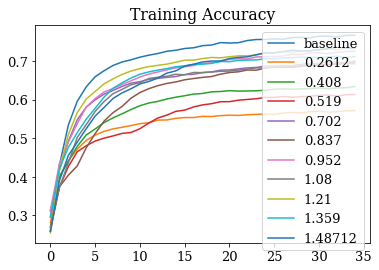

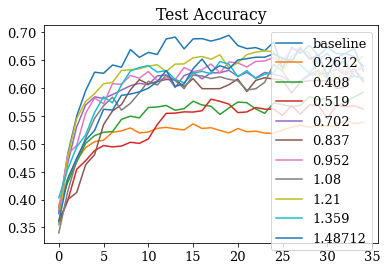

In [6]:
plt.title("Training Accuracy")
plt.plot(base_vgg11["train_acc"], label = "baseline")
plt.plot(bls1_vgg11["train_acc"], label = bls_bpp[0])
plt.plot(bls2_vgg11["train_acc"], label = bls_bpp[1])
plt.plot(bls3_vgg11["train_acc"], label = bls_bpp[2])
plt.plot(bls5_vgg11["train_acc"], label = bls_bpp[3])
plt.plot(bls7_vgg11["train_acc"], label = bls_bpp[4])
plt.plot(bls9_vgg11["train_acc"], label = bls_bpp[5])
plt.plot(bls12_vgg11["train_acc"], label = bls_bpp[6])
plt.plot(bls17_vgg11["train_acc"], label = bls_bpp[7])
plt.plot(bls24_vgg11["train_acc"], label = bls_bpp[8])
plt.plot(bls33_vgg11["train_acc"], label = bls_bpp[9])
plt.legend()
plt.show()

plt.title("Test Accuracy")
plt.plot(base_vgg11["test_acc"], label = "baseline")
plt.plot(bls1_vgg11["test_acc"], label = bls_bpp[0])
plt.plot(bls2_vgg11["test_acc"], label = bls_bpp[1])
plt.plot(bls3_vgg11["test_acc"], label = bls_bpp[2])
plt.plot(bls5_vgg11["test_acc"], label = bls_bpp[3])
plt.plot(bls7_vgg11["test_acc"], label = bls_bpp[4])
plt.plot(bls9_vgg11["test_acc"], label = bls_bpp[5])
plt.plot(bls12_vgg11["test_acc"], label = bls_bpp[6])
plt.plot(bls17_vgg11["test_acc"], label = bls_bpp[7])
plt.plot(bls24_vgg11["test_acc"], label = bls_bpp[8])
plt.plot(bls33_vgg11["test_acc"], label = bls_bpp[9])
plt.legend()
plt.show()

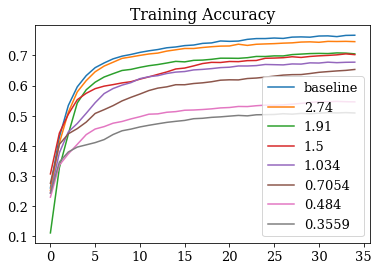

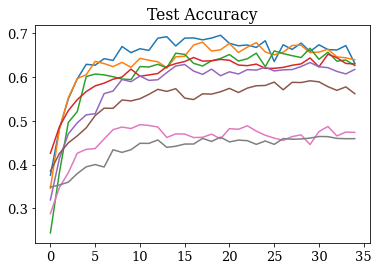

In [7]:
plt.title("Training Accuracy")
plt.plot(base_vgg11["train_acc"], label = "baseline")
plt.plot(jpeg80_vgg11["train_acc"], label = jpeg_bpp[6])
plt.plot(jpeg60_vgg11["train_acc"], label = jpeg_bpp[5])
plt.plot(jpeg40_vgg11["train_acc"], label = jpeg_bpp[4])
plt.plot(jpeg20_vgg11["train_acc"], label = jpeg_bpp[3])
plt.plot(jpeg10_vgg11["train_acc"], label = jpeg_bpp[2])
plt.plot(jpeg5_vgg11["train_acc"], label = jpeg_bpp[1])
plt.plot(jpeg1_vgg11["train_acc"], label = jpeg_bpp[0])
plt.legend()
plt.show()

plt.title("Test Accuracy")
plt.plot(base_vgg11["test_acc"], label = "baseline")
plt.plot(jpeg80_vgg11["test_acc"], label = jpeg_bpp[6])
plt.plot(jpeg60_vgg11["test_acc"], label = jpeg_bpp[5])
plt.plot(jpeg40_vgg11["test_acc"], label = jpeg_bpp[4])
plt.plot(jpeg20_vgg11["test_acc"], label = jpeg_bpp[3])
plt.plot(jpeg10_vgg11["test_acc"], label = jpeg_bpp[2])
plt.plot(jpeg5_vgg11["test_acc"], label = jpeg_bpp[1])
plt.plot(jpeg1_vgg11["test_acc"], label = jpeg_bpp[0])
plt.show()

[(0.2612, 0.408, 0.519, 0.702, 0.837, 0.952, 1.08, 1.21, 1.359, 1.48712), (0.5426, 0.5927, 0.5803, 0.6345, 0.6345, 0.6702, 0.643, 0.6684, 0.6627, 0.6727)]
[0.3606 0.4378 0.4746 0.5065 0.5241 0.5621 0.5607 0.5871 0.5894 0.5934
 0.5999 0.6117 0.6318 0.6032 0.6077 0.635  0.6522 0.6306 0.6403 0.6346
 0.6505 0.6529 0.6556 0.6556 0.6616 0.6537 0.6479 0.6727 0.6523 0.6598
 0.6215 0.6541 0.6623 0.6565 0.6399]
[[0.2612, 0.5426], [0.408, 0.5927], [0.519, 0.5803], [0.702, 0.6345], [0.837, 0.6345], [0.952, 0.6702], [1.08, 0.643], [1.21, 0.6684], [1.359, 0.6627], [1.48712, 0.6727]]


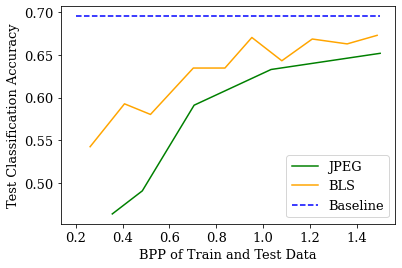

In [11]:
jpeg = [[jpeg_bpp[i], jpeg_results[i]['test_acc'].max()] for i in range(5)]
bls = [[bls_bpp[i], bls_results[i]['test_acc'].max()] for i in range(10)]

print(list(zip(*bls)))
print(bls_results[-1]['test_acc'])

print(bls)


plt.ylabel("Test Classification Accuracy")
plt.xlabel("BPP of Train and Test Data")
plt.plot(*list(zip(*jpeg)), label = "JPEG", color = "green")
plt.plot(*list(zip(*bls)), label = "BLS", color = "orange")
plt.plot(np.linspace(0.2,1.5,10), np.ones(10) * base_vgg11['test_acc'].max(), "--", label = "Baseline", color = "blue")
plt.legend()
plt.savefig("training.png", dpi = 100)